# Experiments for the paper

In [1]:
import jax, jax.numpy as jnp
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import math
from src.utils.misc import tree_dropfirst, tree_droplast

jax.config.update('jax_platform_name', 'gpu')
jax.config.update('jax_enable_x64', False)

from src.stats.hmm import get_generative_model
from src.variational import get_variational_model
from src.utils.misc import tree_get_idx, save_params, tree_get_slice
from src.training import SVITrainer
from src.stats.ula import ULA

def set_defaults(args):
    args.default_prior_mean = 0.0 # default value for the mean of Gaussian prior
    args.default_prior_base_scale = 0.1 # default value for the diagonal components of the covariance matrix of the prior
    args.default_transition_base_scale = 0.1 # default value for the diagonal components of the covariance matrix of the transition kernel
    args.default_transition_bias = 0.0
    args.default_emission_base_scale = 0.1
    args.parametrization = 'cov_chol'
    return args


def plot_x_true_against_x_pred(x_true, x_pred, y=None, save=False):
    dims = x_true.shape[-1]
    _ , axes = plt.subplots(dims, 1, figsize=(15,2*dims))
    for dim in range(dims):
        axes[dim].plot(x_true[:,dim], c='red', label='True', alpha=0.7)
        axes[dim].plot(x_pred[:,dim], c='green', label='Pred', alpha=0.7)
        axes[dim].legend()
        if y is not None:
            axes[dim].plot(y[:,dim], c='black', label='Obs', alpha=0.5)
    if save: plt.savefig('test.pdf', format='pdf')   
    
def plot_data(y):
    dims = y.shape[-1]
    _ , axes = plt.subplots(dims, 1, figsize=(15,2*dims))
    for dim in range(dims):
        axes[dim].plot(y[:,dim], label='Data')

def compute_rmse_x_true_against_x_pred(x_true, x_pred):
    return jnp.mean(jnp.sqrt(jnp.mean((x_true-x_pred)**2, axis=-1)), 
                    axis=0)


/home/mathis/.venvs/jax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Linear-Gaussian HMM 

### Setting up data and generative model

In [ ]:
key = jax.random.PRNGKey(0) # seed
p_args = argparse.Namespace() # will contain all configuration information for the generative model 
p_args.state_dim, p_args.obs_dim = 2,2 # dimensions of state and observation spaces
p_args.model = 'linear'
p_args.seq_length = 500
p_args.emission_bias = False # no bias in the emission kernel, i.e. only Y_t = B X_t + noise
p_args.transition_bias = False # no bias in the transition kernel, i.e. only X_t = A X_{t-1} + noise
p_args.transition_matrix_conditionning = 'diagonal' # the transition matrix will be diagonal
p_args.range_transition_map_params = [0.9,1] # the diagonal values are constrained to [0.9 1]
p_args.num_seqs = 1 #
p_args = set_defaults(p_args) # setting default values for the covariances with realistic Signal to noise ratios

key, key_theta, key_sequences = jax.random.split(key, 3)
p, theta = get_generative_model(p_args, key_theta) # getting the model and its parameters 
# save_args(p_args, 'args', exp_path) # saving the params of the generative model
# save_params(theta, 'theta', exp_path) # saving the parameters
# jnp.save(os.path.join(exp_path, 'xs'), xs)
# jnp.save(os.path.join(exp_path, 'ys'), ys)

In [ ]:
xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     p_args.num_seqs, 
                                     p_args.seq_length,
                                     single_split_seq=False, # not sampling a sequence and splitting into subsequences
                                     load_from='', # not loading from external folder
                                     loaded_seq=False) # not loading sequences

### Setting up variational model and training parameters

In [ ]:
q_args = argparse.Namespace() # will contain all configuration information for the variational model 
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim 
q_args.model = 'linear' 
q_args.emission_bias = False 
q_args.transition_bias = False 
q_args.transition_matrix_conditionning = 'diagonal' 
q_args.range_transition_map_params = [0.9,1] 
q_args = set_defaults(q_args) 
# sub_exp_path = os.path.join(exp_path, q_args.model)
# os.makedirs(sub_exp_path, exist_ok=True)
# save_args(p_args, 'args', sub_exp_path) # saving the params of the generative model
q = get_variational_model(q_args) # getting the corresponding model


### Learning in an offline setting

In [ ]:
key = jax.random.PRNGKey(1)
for elbo_mode in ['closed_form', 'autodiff_on_batch', 'score,paris,bptt_depth_2']:
    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=1e-3, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=1000, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=2, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode=f'reset,{p_args.seq_length},1', 
                        elbo_mode=elbo_mode,
                        logging_type='basic_logging')


    key_init_params, key_montecarlo = jax.random.split(key, 2)
    fitted_variational_params, elbos = trainer.fit(key_init_params, 
                                    key_montecarlo, 
                                    data=(xs, ys), 
                                    log_writer=None, 
                                    args=q_args, 
                                    log_writer_monitor=None)

    elbo_for_all_epochs = elbos.flatten()
    plt.plot(elbo_for_all_epochs, label=elbo_mode)
plt.legend()

In [ ]:
print(fitted_variational_params)
x_smoothed_kalman = p.smooth_seq(ys[0], theta)[0]
x_smoothed_variational = q.smooth_seq(ys[0], fitted_variational_params)[0]
plot_x_true_against_x_pred(x_smoothed_kalman, x_smoothed_variational)

### Streaming data

In [ ]:
p_args.seq_length = 100_000 # keeping all previous settings except the sequence length

xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     num_seqs=1, 
                                     seq_length=p_args.seq_length,
                                     single_split_seq=False,
                                     load_from='')


In [ ]:
ula = ULA(p)
fitted_params = ula.learn_params(key, 
                                 ys[0], 
                                 p.get_random_params(key, 
                                                     p_args))

In [ ]:
elbo_mode = 'score,paris,bptt_depth_2'
trainer = SVITrainer(p=p,
                    theta_star=theta,
                    q=q,
                    optimizer='adam',
                    learning_rate=1e-3, 
                    optim_options='cst', # learning rate schedule
                    num_epochs=1, # number of full sweeps through the sequence
                    seq_length=p_args.seq_length,
                    num_samples=20, # number of monte carlo samples (or trajectories in the online case)
                    frozen_params='', # which parameters to hold fixed
                    num_seqs=p_args.num_seqs, 
                    training_mode=f'streaming,1,difference', # L_t - L_{t-1} / t
                    elbo_mode=elbo_mode,
                    logging_type='basic_logging')

key_init_params, key_montecarlo = jax.random.split(key, 2)
fitted_variational_params, elbos = trainer.fit(key_init_params, 
                                key_montecarlo, 
                                data=(xs, ys), 
                                args=None)

In [ ]:
elbo_for_all_epochs = elbos.flatten()
plt.plot(elbo_for_all_epochs, label=elbo_mode)
plt.legend()

x_smoothed_kalman = p.smooth_seq(ys[0][:1000], theta)[0]
x_smoothed_variational = q.smooth_seq(ys[0][:1000], fitted_variational_params)[0]
plot_x_true_against_x_pred(x_smoothed_kalman, x_smoothed_variational)

## Chaotic RNN

### Setting up model and data

In [13]:
p_args = argparse.Namespace()
key = jax.random.PRNGKey(0)

p_args.state_dim, p_args.obs_dim = 5,5
p_args.model = 'chaotic_rnn' 
p_args.seq_length = 5_00
p_args.loaded_seq = False
p_args.load_from = 'data/crnn/2022-10-18_15-28-00_Train_run'
p_args.range_transition_map_params = [0.8,1] # range of the components of the transition matrix
p_args.transition_matrix_conditionning = 'init_scale_by_dim' # constraint
p_args.default_transition_matrix = os.path.join(p_args.load_from, 
                                                 'W.npy')

p_args.gamma = 2.5 # gamma for the chaotic rnn
p_args.tau = 0.025 # tau for the chaotic rnn
p_args.grid_size = 0.001 # discretization parameter for the chaotic rnn

p_args.emission_matrix_conditionning = 'diagonal'
p_args.range_emission_map_params = [-1,1]
p_args.default_emission_df = 2 # degrees of freedom for the emission noise
p_args.default_emission_matrix = 1.0 # diagonal values for the emission matrix
p_args.transition_bias = False 
p_args.emission_bias = False
p_args.num_seqs = 1 #

p_args = set_defaults(p_args)
p_args.num_particles, p_args.num_smooth_particles = None, None

key, key_params, key_sequences = jax.random.split(key, 3)
p, theta = get_generative_model(p_args, key_params)
xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     1, 
                                     p_args.seq_length,
                                     single_split_seq=False)


/home/mathis/.venvs/jax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


### Setting up variational model

### Side-by-side comparison with Campbell et al.

#### Nonamortized training

In [33]:
q_args = argparse.Namespace()
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim 
q_args.model = 'nonamortized'
q_args.backwd_layers = (100,) # the number of neurons in the hidden layers of the NN that predicts backward parameters

q_args = set_defaults(q_args)

q = get_variational_model(q_args)

for elbo_mode in ['score,truncated,paris,bptt_depth_1']:
    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=1e-2, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=1, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=2, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode='streaming,10', # 10 gradient steps per timestep should be enough to have stabilized q_t at each t
                        elbo_mode=elbo_mode)

    key_init_params, key_montecarlo = jax.random.split(key, 2)
    fitted_variational_params, elbos, aux_results, all_params = trainer.fit(key_init_params, 
                                    key_montecarlo, 
                                    data=(xs, ys), 
                                    args=q_args)
    

    all_params = tree_get_idx(0, all_params)

    # elbo_for_all_epochs = elbos.flatten()
    # plt.plot(elbo_for_all_epochs, label=elbo_mode)
# plt.legend()


Num params: 1120
USING SCORE ELBO.
Using truncated gradients.


Running for 500 iterations: 100%|██████████| 500/500 [00:01<00:00, 257.20it/s]


#### Comparing the means of $q_t^{\lambda_{t}}$ to the true states $x_t^{*}$.

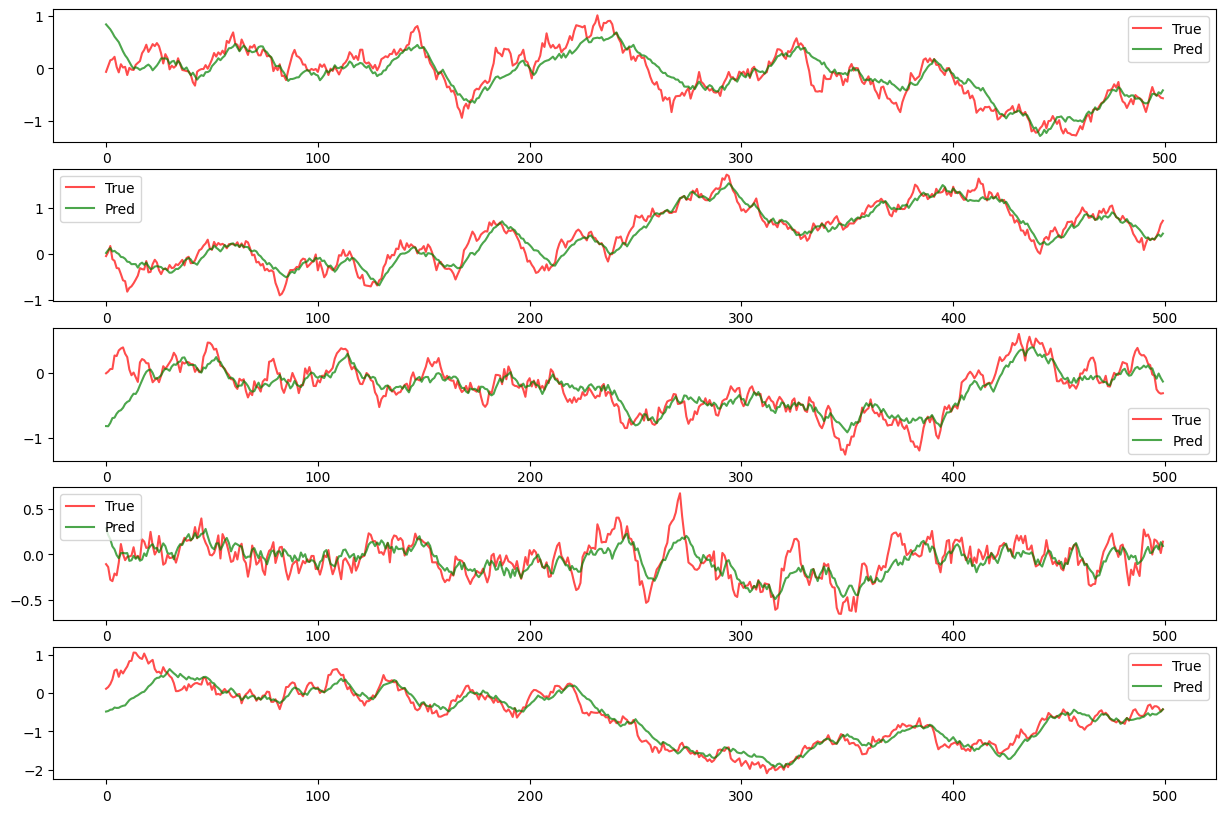

In [32]:
x_true = xs[0]
plot_x_true_against_x_pred(x_true, all_params.filt.mean)#, y = all_params.filt.mean)

#### Comparing the 1-step smoothing means $\hat{x}_{t-1|t} = \int x_{t-1} q_{t-1|t}^{\lambda_{t-1}} (x_t, x_{t-1}) q_t^{\lambda_t}(d x_t)$ to the true states $x_{t-1}^{*}$.

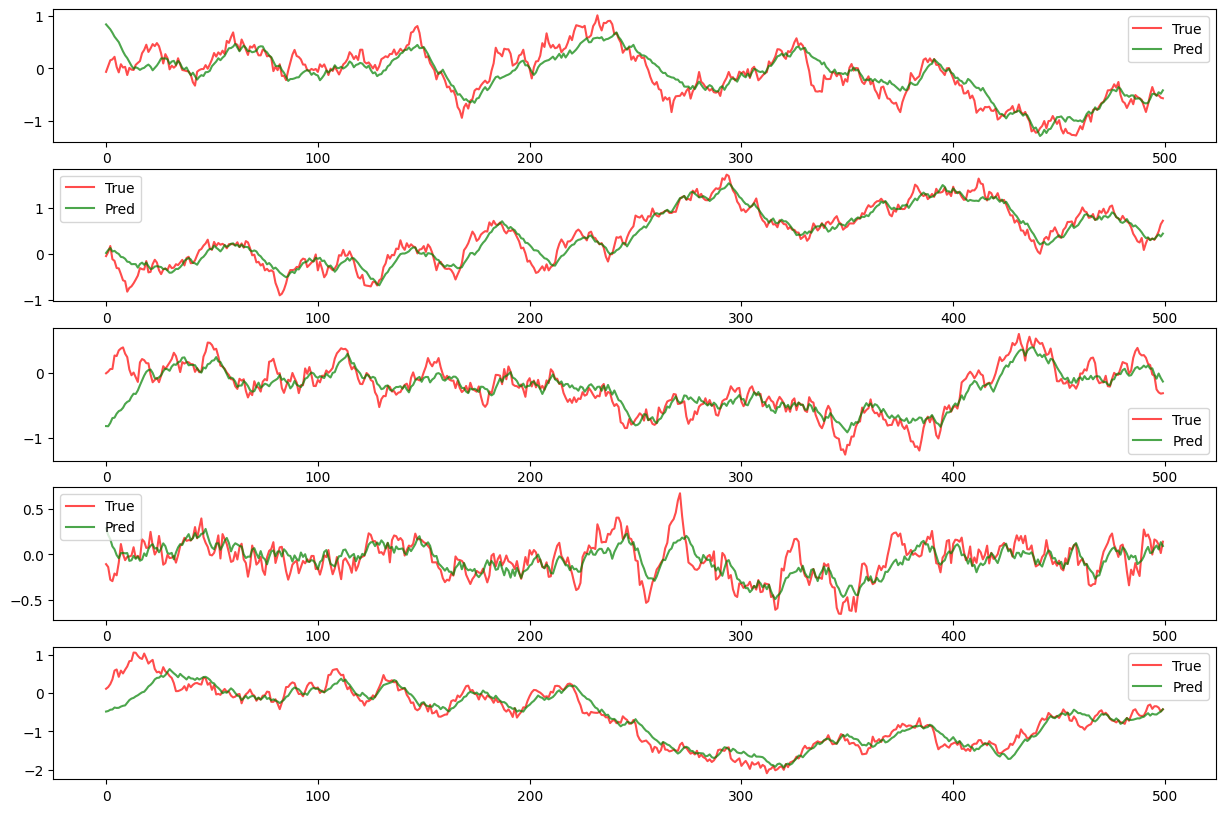

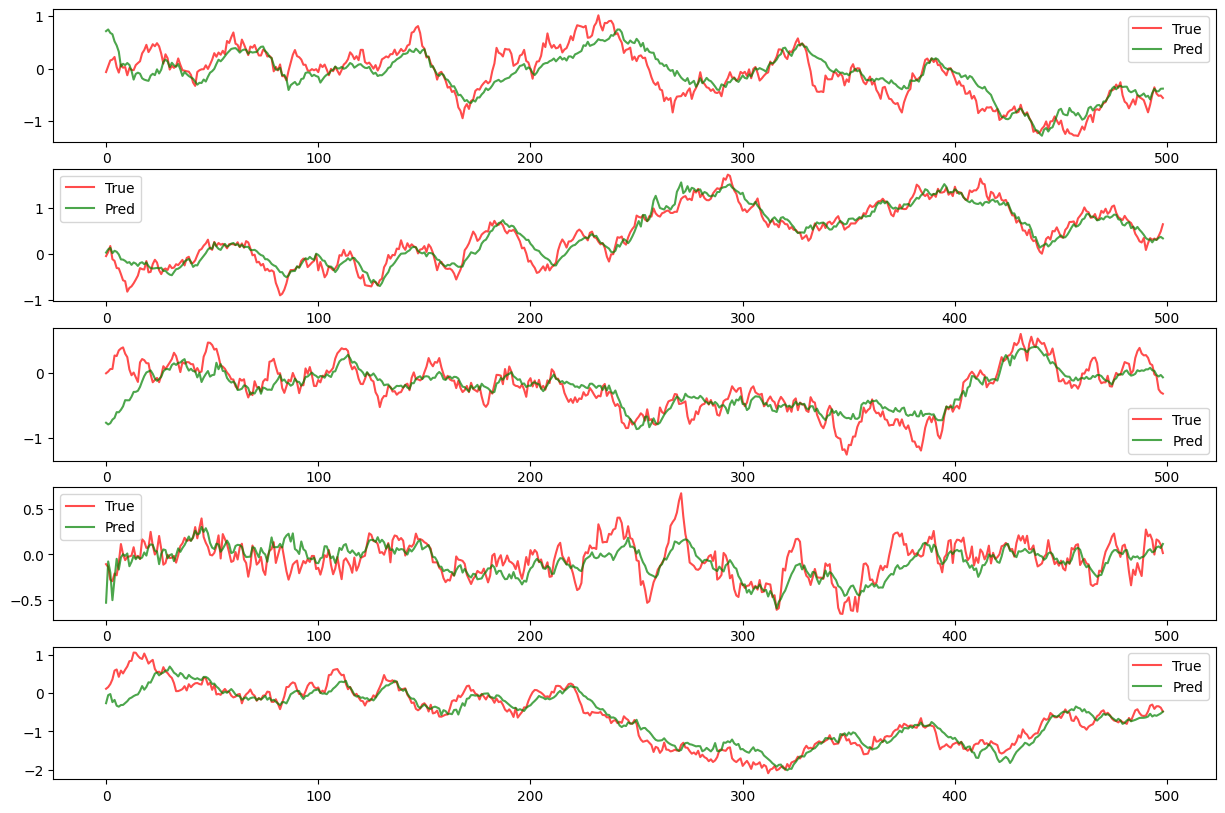

In [31]:
num_samples = 10_000

def x_tm1_t(carry, x): 
    key, filt_params_tm1, filt_params_t, backwd_params_net_t = x
    key, subkey = jax.random.split(key, 2)
    

    filt_params_tm1 = q.filt_dist.format_params(filt_params_tm1)
    filt_params_t = q.filt_dist.format_params(filt_params_t)

    x_t = jax.vmap(q.filt_dist.sample, in_axes=(0, None))(jax.random.split(key, num_samples), 
                                                          filt_params_t)
    
    backwd_params_t = (backwd_params_net_t, (filt_params_tm1, filt_params_t))

    x_tm1 = jax.vmap(q.backwd_kernel.sample, in_axes=(0,0, None))(jax.random.split(subkey, 
                                                                                   num_samples), 
                                                                    x_t, backwd_params_t)

    return None, jnp.mean(x_tm1, axis=0)



_, x_smoothed_tm1 = jax.lax.scan(x_tm1_t, 
                              init=None,
                              xs=(jax.random.split(key, p_args.seq_length-1), 
                                   tree_droplast(all_params.filt),
                                   tree_dropfirst(all_params.filt),
                                   tree_dropfirst(all_params.backwd)))

plot_x_true_against_x_pred(x_true[:-1], x_smoothed_tm1)#, y = all_params.filt.mean)

### Learning on streaming data

In [ ]:
key = jax.random.PRNGKey(1)


p_args.state_dim, p_args.obs_dim = 10,10
p_args.model = 'chaotic_rnn' 
p_args.seq_length = 100_000
p_args.loaded_seq = False
p_args.load_from = '' #data/crnn/2022-10-18_15-28-00_Train_run'
p_args.range_transition_map_params = [0.8,1] # range of the components of the transition matrix
p_args.transition_matrix_conditionning = 'init_scale_by_dim' # constraint
p_args.default_transition_matrix = '' #os.path.join(p_args.load_from, 'W.npy')

q_args = argparse.Namespace()
q_args.model = 'johnson_backward,100'
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim
q_args.transition_bias = False
q_args.emission_bias = False
layers = [int(nb) for nb in q_args.model.split(',')[-1].split('_')]
q_args.update_layers = (*layers,)
q_args.backwd_layers = 0
q_args.transition_matrix_conditionning = 'diagonal'
q_args.range_transition_map_params = (0.9, 1)
q_args.anisotropic = False

q_args = set_defaults(q_args)

q = get_variational_model(q_args)

for elbo_mode in ['score,paris,bptt_depth_2']:

    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=1e-3, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=1, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=100, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode='streaming,1,difference', 
                        elbo_mode=elbo_mode)


    key_init_params, key_montecarlo = jax.random.split(key, 2)
    
    fitted_variational_params, elbos, aux_results, all_params = trainer.fit(key_init_params, 
                                    key_montecarlo, 
                                    data=(xs, ys), 
                                    args=q_args)
    
    elbo_for_all_epochs = elbos.flatten()

In [ ]:
steps = jnp.arange(0, 100_000, 10_000)
all_params = tree_get_idx(-1, 
                          jax.tree_map(lambda x: jnp.take(x, indices=steps, axis=1), 
                                       all_params))

eval_length = 5_000
x_true = xs[0][:eval_length]
y = ys[0][:eval_length]

alphas = jnp.linspace(0.2,1,len(steps)).tolist()

plt.plot(elbo_for_all_epochs, label='ELBO', c='black')
plt.xlabel('Timestep')
plt.ylabel('ELBO')
plt.vlines(x=steps, ymin=-100, ymax=0, alpha=alphas, linestyles='dotted', colors='black')

plt.savefig('ELBO.pdf', format='pdf')


dims = p_args.state_dim
_ , axes = plt.subplots(dims, 1, figsize=(15,2*dims))
for dim in range(dims): 
    axes[dim].plot(x_true[:,dim], c='red', label='True', alpha=0.7)
    axes[dim].set_xlabel('Timestep')
    axes[dim].set_ylabel(f'States dim {dim}')
rmse_values = []
for idx, (step, alpha) in enumerate(zip(steps, alphas)):
    params = tree_get_idx(idx, all_params)
    x_smoothed = q.smooth_seq(y, params)[0]
    rmse_values.append(compute_rmse_x_true_against_x_pred(x_true, 
                                                          x_smoothed))
    for dim in range(dims): 
        axes[dim].plot(x_smoothed[:,dim], linestyle='dotted', c='black', label=f'Step {step}', alpha=alpha)
plt.savefig('smoothing_multiple_params.pdf', format='pdf')